In [19]:
import torch as th
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 18})

import matplotlib.pyplot as plt

# set random seed

# exponent 0
# esponent 7
# exponent 9

#bw 30 Mbps
# bw 20 Mbps
# bw 10 Mbps




# seed =53444
# np.random.seed(seed)
# th.manual_seed(seed)
# th.cuda.manual_seed(seed)
# th.backends.cudnn.deterministic = True

def classic_diane_sampling(points: th.Tensor,
                           bandwidth_bps: float = 20e6,
                           fps: int = 10,
                           psz_bits: int = 4 * 16,
                           λ: float = 7,
                           d_guaranteed: float = 3.0) -> tuple[th.Tensor, float, int]:
    """
    Apply Classic DIANE sampling on a point cloud tensor with bandwidth constraints.

    Args:
        points (th.Tensor): Tensor of shape (N, 4) where columns are (x, y, z, validity).
        bandwidth_bps (float): Link bandwidth in bits per second (default: 20 Mbps).
        fps (int): Frame rate in frames per second (default: 10).
        psz_bits (int): Size of a single point in bits (default: 4 channels × 16 bits = 64 bits).
        λ (float): Exponent for the DIANE validity function (default: 7).
        d_guaranteed (float): Z-threshold under which all points are guaranteed to be included (default: 3.0 m).

    Returns:
        sampled_points (th.Tensor): Sampled point cloud tensor.
        elapsed_time_ms (float): CUDA timing for sampling (in milliseconds).
        frame_size_bits (int): Total size of the sampled frame (in bits).
    """
    assert points.shape[1] >= 3, "Points tensor must have at least 3 columns (x, y, z)."

    # Calculate maximum number of points per frame under bandwidth constraints
    mfs_bits = bandwidth_bps / fps  # Maximum Frame Size in bits
    num_points_available = points.shape[0]
    max_points = int(min(mfs_bits / psz_bits, num_points_available))

    # send atleast 10% of the PC

    #max_points = max(max_points, int(0.1 * num_points_available))

    # ensure max_points is a multiple of 150

    max_points = (max_points // 150) * 150

    # Create CUDA timers
    tic = th.cuda.Event(enable_timing=True)
    toc = th.cuda.Event(enable_timing=True)

    # Compute DIANE validity function
    z_vals = points[:, 2]
    # diane_validity = 1 / ((z_vals/th.max(z_vals))**λ + 1e-6)
    diane_validity = 1 / ((z_vals/th.max(z_vals))**λ + 1e-6)
    diane_validity[z_vals < d_guaranteed] = th.max(diane_validity)
   
    
    




    # Sampling
    tic.record()
    indices = th.multinomial(diane_validity, max_points, replacement=False)
    sampled_points = points[indices]
    toc.record()

    th.cuda.synchronize()
    elapsed_time_ms = tic.elapsed_time(toc)
    frame_size_bits = psz_bits * sampled_points.size(0)

    return sampled_points, elapsed_time_ms, frame_size_bits, diane_validity



# a tensor 480x480x4  pxl, pxl,(x,y,z,validity)



BW = 20 * 1e6 # Bandwidth in bits per second
FPS = 10
MFS = BW / FPS # Maximum Frame Size in bits
PSZ = 4 * 16 # 4 channels of 16 bits each

NUM_POINTS = 480 * 480 # Number of points in the point cloud

D_Guaranteed = 3.85 # meters
λ = 20

# read points from ../dataset/pointclouds/local.ply

points = th.from_numpy(np.loadtxt("work/pcls/local1.ply", skiprows=11, delimiter=" ", usecols=(0,1,2,3), max_rows=NUM_POINTS)).float()

print("points.shape", points.shape)

## change the sign of z values

points[:,2] = -points[:,2]

# points = (th.rand(480, 480, 4)*20).view(-1, 4).float()


valid_points_40_9, time_40, frame_size_40, validity_40_9 = classic_diane_sampling(points, bandwidth_bps=40e6, fps=FPS, psz_bits=PSZ, λ=9, d_guaranteed=D_Guaranteed)
valid_points_30_9, time_30, frame_size_30, validity_30_9 = classic_diane_sampling(points, bandwidth_bps=30e6, fps=FPS, psz_bits=PSZ, λ=9, d_guaranteed=D_Guaranteed)
valid_points_20_9, time_20, frame_size_20, validity_20_9 = classic_diane_sampling(points, bandwidth_bps=20e6, fps=FPS, psz_bits=PSZ, λ=9, d_guaranteed=D_Guaranteed)
valid_points_15_9, time_15, frame_size_15, validity_15_9 = classic_diane_sampling(points, bandwidth_bps=15e6, fps=FPS, psz_bits=PSZ, λ=9, d_guaranteed=D_Guaranteed)
valid_points_10_9, time_10, frame_size_10, validity_10_9 = classic_diane_sampling(points, bandwidth_bps=10e6, fps=FPS, psz_bits=PSZ, λ=9, d_guaranteed=D_Guaranteed)
valid_points_5_9, time_5, frame_size_5, validity_5_9 = classic_diane_sampling(points, bandwidth_bps=5e6, fps=FPS, psz_bits=PSZ, λ=9, d_guaranteed=D_Guaranteed)

# print points taken
print("----------------------------------------------------------------------------------------------------------------------------")
print("Valid points at 40 Mbps with λ=9:", valid_points_40_9.shape[0], "Time:", time_40, "ms, Frame size:", frame_size_40, "bits")
print("Valid points at 30 Mbps with λ=9:", valid_points_30_9.shape[0], "Time:", time_30, "ms, Frame size:", frame_size_30, "bits")
print("Valid points at 20 Mbps with λ=9:", valid_points_20_9.shape[0], "Time:", time_20, "ms, Frame size:", frame_size_20, "bits")
print("Valid points at 15 Mbps with λ=9:", valid_points_15_9.shape[0], "Time:", time_15, "ms, Frame size:", frame_size_15, "bits")
print("Valid points at 10 Mbps with λ=9:", valid_points_10_9.shape[0], "Time:", time_10, "ms, Frame size:", frame_size_10, "bits")
print("Valid points at 5 Mbps with λ=9:", valid_points_5_9.shape[0], "Time:", time_5, "ms, Frame size:", frame_size_5, "bits")
print("max validity at 40 Mbps with λ=9:", th.max(validity_40_9))
print("max validity at 30 Mbps with λ=9:", th.max(validity_30_9))
print("max validity at 20 Mbps with λ=9:", th.max(validity_20_9))
print("max validity at 15 Mbps with λ=9:", th.max(validity_15_9))
print("max validity at 10 Mbps with λ=9:", th.max(validity_10_9))
print("max validity at 5 Mbps with λ=9:", th.max(validity_5_9))

valid_points_40_7, time_40, frame_size_40, validity_40_7 = classic_diane_sampling(points, bandwidth_bps=40e6, fps=FPS, psz_bits=PSZ, λ=7.0, d_guaranteed=D_Guaranteed)
valid_points_30_7, time_30, frame_size_30, validity_30_7 = classic_diane_sampling(points, bandwidth_bps=30e6, fps=FPS, psz_bits=PSZ, λ=7.0, d_guaranteed=D_Guaranteed)
valid_points_20_7, time_20, frame_size_20, validity_20_7 = classic_diane_sampling(points, bandwidth_bps=20e6, fps=FPS, psz_bits=PSZ, λ=7.0, d_guaranteed=D_Guaranteed)
valid_points_15_7, time_15, frame_size_15, validity_15_7 = classic_diane_sampling(points, bandwidth_bps=15e6, fps=FPS, psz_bits=PSZ, λ=7.0, d_guaranteed=D_Guaranteed)
valid_points_10_7, time_10, frame_size_10, validity_10_7 = classic_diane_sampling(points, bandwidth_bps=10e6, fps=FPS, psz_bits=PSZ, λ=7.0, d_guaranteed=D_Guaranteed)
valid_points_5_7, time_5, frame_size_5, validity_5_7 = classic_diane_sampling(points, bandwidth_bps=5e6, fps=FPS, psz_bits=PSZ, λ=7.0, d_guaranteed=D_Guaranteed)

# print points taken
print("----------------------------------------------------------------------------------------------------------------------------")
print("Valid points at 40 Mbps with λ=7:", valid_points_40_7.shape[0], "Time:", time_40, "ms, Frame size:", frame_size_40, "bits")
print("Valid points at 30 Mbps with λ=7:", valid_points_30_7.shape[0], "Time:", time_30, "ms, Frame size:", frame_size_30, "bits")
print("Valid points at 20 Mbps with λ=7:", valid_points_20_7.shape[0], "Time:", time_20, "ms, Frame size:", frame_size_20, "bits")
print("Valid points at 15 Mbps with λ=7:", valid_points_15_7.shape[0], "Time:", time_15, "ms, Frame size:", frame_size_15, "bits")
print("Valid points at 10 Mbps with λ=7:", valid_points_10_7.shape[0], "Time:", time_10, "ms, Frame size:", frame_size_10, "bits")
print("Valid points at 5 Mbps with λ=7:", valid_points_5_7.shape[0], "Time:", time_5, "ms, Frame size:", frame_size_5, "bits")
print("max validity at 40 Mbps with λ=7:", th.max(validity_40_7))
print("max validity at 30 Mbps with λ=7:", th.max(validity_30_7))
print("max validity at 20 Mbps with λ=7:", th.max(validity_20_7))
print("max validity at 15 Mbps with λ=7:", th.max(validity_15_7))
print("max validity at 10 Mbps with λ=7:", th.max(validity_10_7))
print("max validity at 5 Mbps with λ=7:", th.max(validity_5_7))


valid_points_40_3, time_40, frame_size_40, validity_40_3 = classic_diane_sampling(points, bandwidth_bps=40e6, fps=FPS, psz_bits=PSZ, λ=3.0, d_guaranteed=D_Guaranteed)
valid_points_30_3, time_30, frame_size_30, validity_30_3 = classic_diane_sampling(points, bandwidth_bps=30e6, fps=FPS, psz_bits=PSZ, λ=3.0, d_guaranteed=D_Guaranteed)
valid_points_20_3, time_20, frame_size_20, validity_20_3 = classic_diane_sampling(points, bandwidth_bps=20e6, fps=FPS, psz_bits=PSZ, λ=3.0, d_guaranteed=D_Guaranteed)
valid_points_15_3, time_15, frame_size_15, validity_15_3 = classic_diane_sampling(points, bandwidth_bps=15e6, fps=FPS, psz_bits=PSZ, λ=3.0, d_guaranteed=D_Guaranteed)
valid_points_10_3, time_10, frame_size_10, validity_10_3 = classic_diane_sampling(points, bandwidth_bps=10e6, fps=FPS, psz_bits=PSZ, λ=3.0, d_guaranteed=D_Guaranteed)
valid_points_5_3, time_5, frame_size_5, validity_5_3 = classic_diane_sampling(points, bandwidth_bps=5e6, fps=FPS, psz_bits=PSZ, λ=3.0, d_guaranteed=D_Guaranteed)
# print points taken
print("----------------------------------------------------------------------------------------------------------------------------")
print("Valid points at 40 Mbps with λ=3:", valid_points_40_3.shape[0], "Time:", time_40, "ms, Frame size:", frame_size_40, "bits")
print("Valid points at 30 Mbps with λ=3:", valid_points_30_3.shape[0], "Time:", time_30, "ms, Frame size:", frame_size_30, "bits")
print("Valid points at 20 Mbps with λ=3:", valid_points_20_3.shape[0], "Time:", time_20, "ms, Frame size:", frame_size_20, "bits")
print("Valid points at 15 Mbps with λ=3:", valid_points_15_3.shape[0], "Time:", time_15, "ms, Frame size:", frame_size_15, "bits")
print("Valid points at 10 Mbps with λ=3:", valid_points_10_3.shape[0], "Time:", time_10, "ms, Frame size:", frame_size_10, "bits")
print("Valid points at 5 Mbps with λ=3:", valid_points_5_3.shape[0], "Time:", time_5, "ms, Frame size:", frame_size_5, "bits")
# Sampling with λ=1.0 and d_guaranteed=3.0 m


valid_points_40_1, time_40, frame_size_40, validity_40_1 = classic_diane_sampling(points, bandwidth_bps=40e6, fps=FPS, psz_bits=PSZ, λ=1.0, d_guaranteed=D_Guaranteed)
valid_points_30_1, time_30, frame_size_30, validity_30_1 = classic_diane_sampling(points, bandwidth_bps=30e6, fps=FPS, psz_bits=PSZ, λ=1.0, d_guaranteed=D_Guaranteed)
valid_points_20_1, time_20, frame_size_20, validity_20_1 = classic_diane_sampling(points, bandwidth_bps=20e6, fps=FPS, psz_bits=PSZ, λ=1.0, d_guaranteed=D_Guaranteed)
valid_points_15_1, time_15, frame_size_15, validity_15_1 = classic_diane_sampling(points, bandwidth_bps=15e6, fps=FPS, psz_bits=PSZ, λ=1.0, d_guaranteed=D_Guaranteed)
valid_points_10_1, time_10, frame_size_10, validity_10_1 = classic_diane_sampling(points, bandwidth_bps=10e6, fps=FPS, psz_bits=PSZ, λ=1.0, d_guaranteed=D_Guaranteed)
valid_points_5_1, time_5, frame_size_5, validity_5_1 = classic_diane_sampling(points, bandwidth_bps=5e6, fps=FPS, psz_bits=PSZ, λ=1.0, d_guaranteed=D_Guaranteed)

# print points taken
print("----------------------------------------------------------------------------------------------------------------------------")
print("Valid points at 40 Mbps with λ=1:", valid_points_40_1.shape[0], "Time:", time_40, "ms, Frame size:", frame_size_40, "bits")
print("Valid points at 30 Mbps with λ=1:", valid_points_30_1.shape[0], "Time:", time_30, "ms, Frame size:", frame_size_30, "bits")
print("Valid points at 20 Mbps with λ=1:", valid_points_20_1.shape[0], "Time:", time_20, "ms, Frame size:", frame_size_20, "bits")
print("Valid points at 15 Mbps with λ=1:", valid_points_15_1.shape[0], "Time:", time_15, "ms, Frame size:", frame_size_15, "bits")
print("Valid points at 10 Mbps with λ=1:", valid_points_10_1.shape[0], "Time:", time_10, "ms, Frame size:", frame_size_10, "bits")
print("Valid points at 5 Mbps with λ=1:", valid_points_5_1.shape[0], "Time:", time_5, "ms, Frame size:", frame_size_5, "bits")

valid_points_40_0, time_40, frame_size_40, validity_40_0 = classic_diane_sampling(points, bandwidth_bps=40e6, fps=FPS, psz_bits=PSZ, λ=0.0, d_guaranteed=D_Guaranteed)
valid_points_30_0, time_30, frame_size_30, validity_30_0 = classic_diane_sampling(points, bandwidth_bps=30e6, fps=FPS, psz_bits=PSZ, λ=0.0, d_guaranteed=D_Guaranteed)
valid_points_20_0, time_20, frame_size_20, validity_20_0 = classic_diane_sampling(points, bandwidth_bps=20e6, fps=FPS, psz_bits=PSZ, λ=0.0, d_guaranteed=D_Guaranteed)
valid_points_15_0, time_15, frame_size_15, validity_15_0 = classic_diane_sampling(points, bandwidth_bps=15e6, fps=FPS, psz_bits=PSZ, λ=0.0, d_guaranteed=D_Guaranteed)
valid_points_10_0, time_10, frame_size_10, validity_10_0 = classic_diane_sampling(points, bandwidth_bps=10e6, fps=FPS, psz_bits=PSZ, λ=0.0, d_guaranteed=D_Guaranteed)
valid_points_5_0, time_5, frame_size_5, validity_5_0 = classic_diane_sampling(points, bandwidth_bps=5e6, fps=FPS, psz_bits=PSZ, λ=0.0, d_guaranteed=D_Guaranteed)

# print points taken
print("----------------------------------------------------------------------------------------------------------------------------")
print("Valid points at 40 Mbps with λ=0:", valid_points_40_0.shape[0], "Time:", time_40, "ms, Frame size:", frame_size_40, "bits")
print("Valid points at 30 Mbps with λ=0:", valid_points_30_0.shape[0], "Time:", time_30, "ms, Frame size:", frame_size_30, "bits")
print("Valid points at 20 Mbps with λ=0:", valid_points_20_0.shape[0], "Time:", time_20, "ms, Frame size:", frame_size_20, "bits")
print("Valid points at 15 Mbps with λ=0:", valid_points_15_0.shape[0], "Time:", time_15, "ms, Frame size:", frame_size_15, "bits")
print("Valid points at 10 Mbps with λ=0:", valid_points_10_0.shape[0], "Time:", time_10, "ms, Frame size:", frame_size_10, "bits")
print("Valid points at 5 Mbps with λ=0:", valid_points_5_0.shape[0], "Time:", time_5, "ms, Frame size:", frame_size_5, "bits")


points.shape torch.Size([230400, 4])
----------------------------------------------------------------------------------------------------------------------------
Valid points at 40 Mbps with λ=9: 62400 Time: 5.1282877922058105 ms, Frame size: 3993600 bits
Valid points at 30 Mbps with λ=9: 46800 Time: 3.9185280799865723 ms, Frame size: 2995200 bits
Valid points at 20 Mbps with λ=9: 31200 Time: 3.3320960998535156 ms, Frame size: 1996800 bits
Valid points at 15 Mbps with λ=9: 23400 Time: 2.288640022277832 ms, Frame size: 1497600 bits
Valid points at 10 Mbps with λ=9: 15600 Time: 1.73471999168396 ms, Frame size: 998400 bits
Valid points at 5 Mbps with λ=9: 7800 Time: 1.901568055152893 ms, Frame size: 499200 bits
max validity at 40 Mbps with λ=9: tensor(68979.3672)
max validity at 30 Mbps with λ=9: tensor(68979.3672)
max validity at 20 Mbps with λ=9: tensor(68979.3672)
max validity at 15 Mbps with λ=9: tensor(68979.3672)
max validity at 10 Mbps with λ=9: tensor(68979.3672)
max validity at 5

min_z tensor(2.3014)
max_z tensor(7.9997)


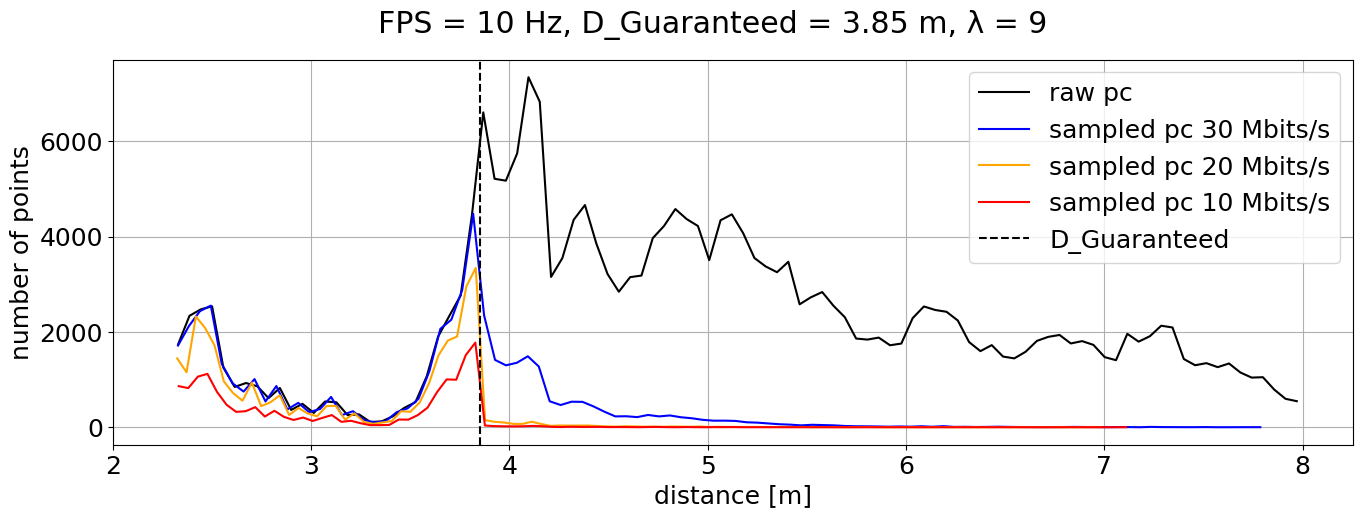

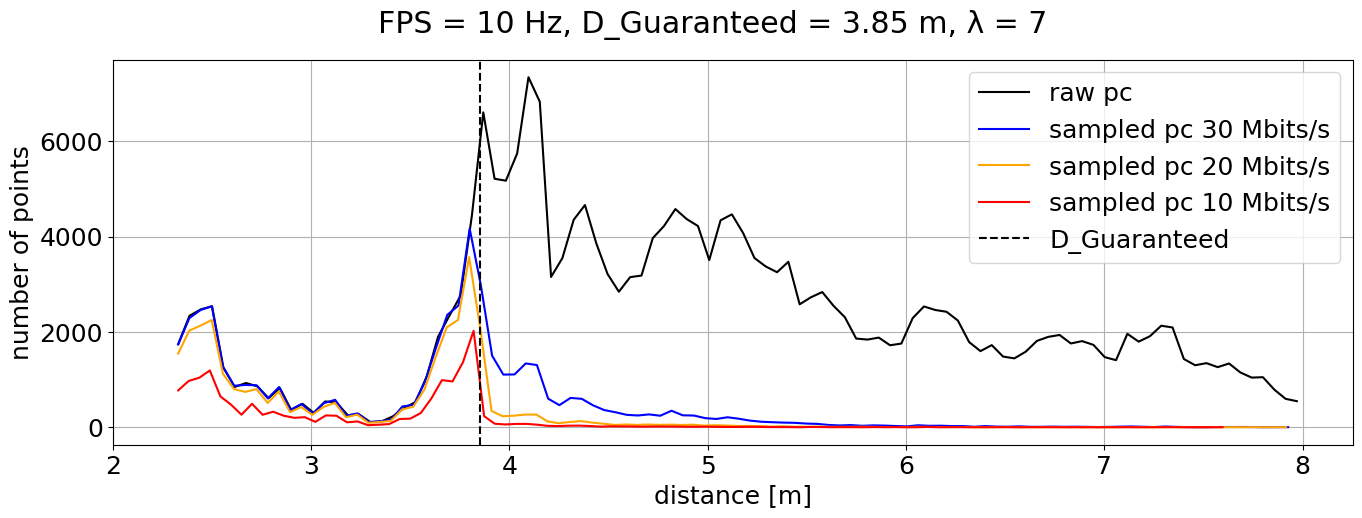

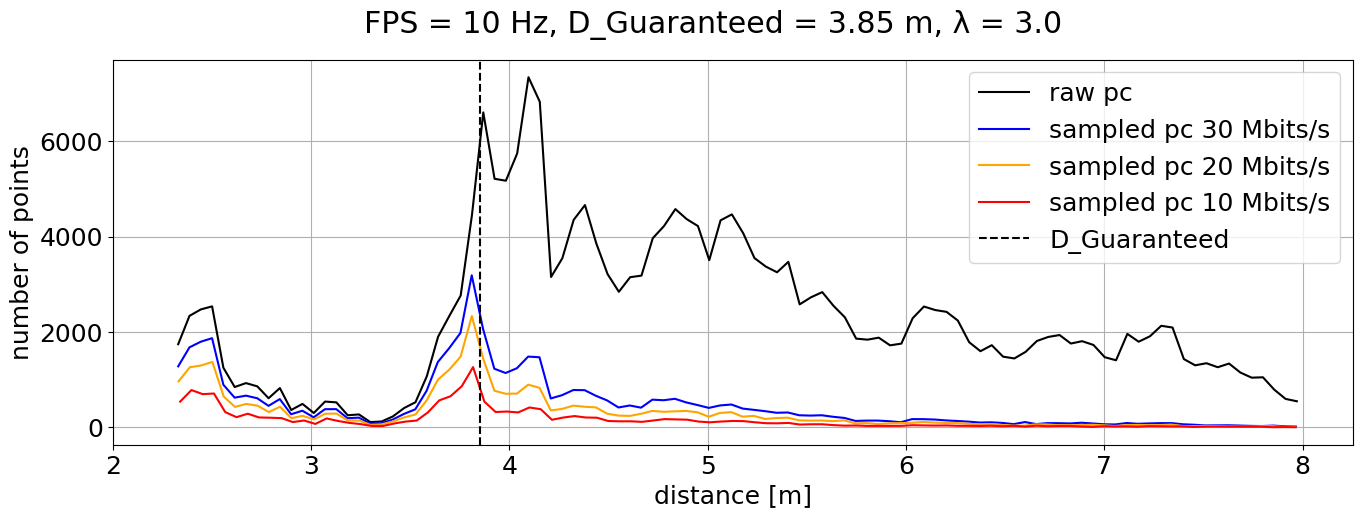

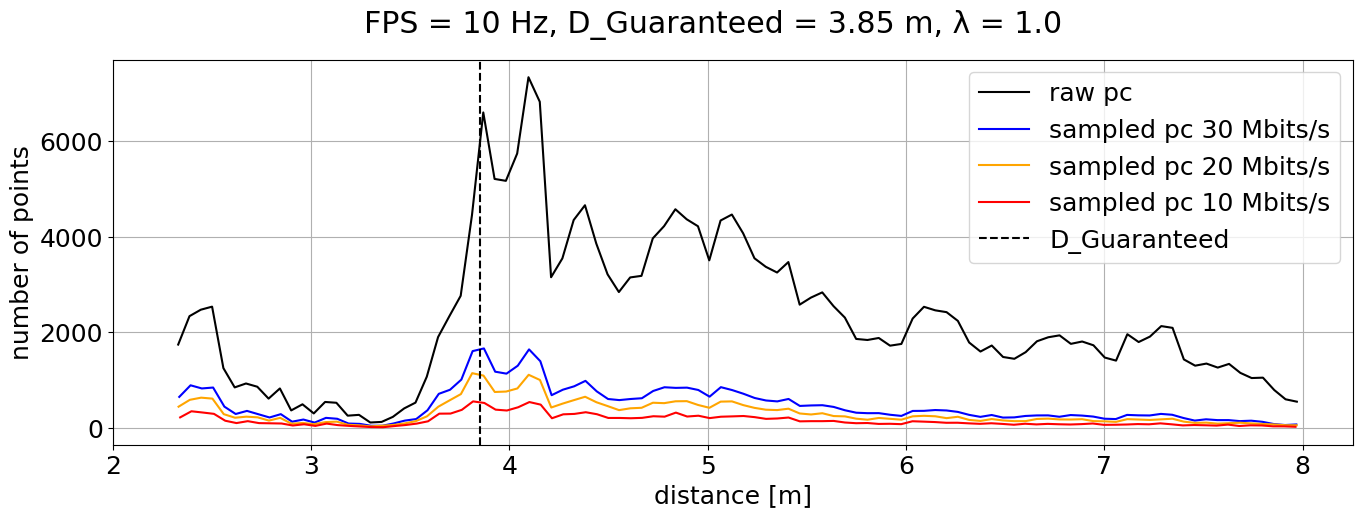

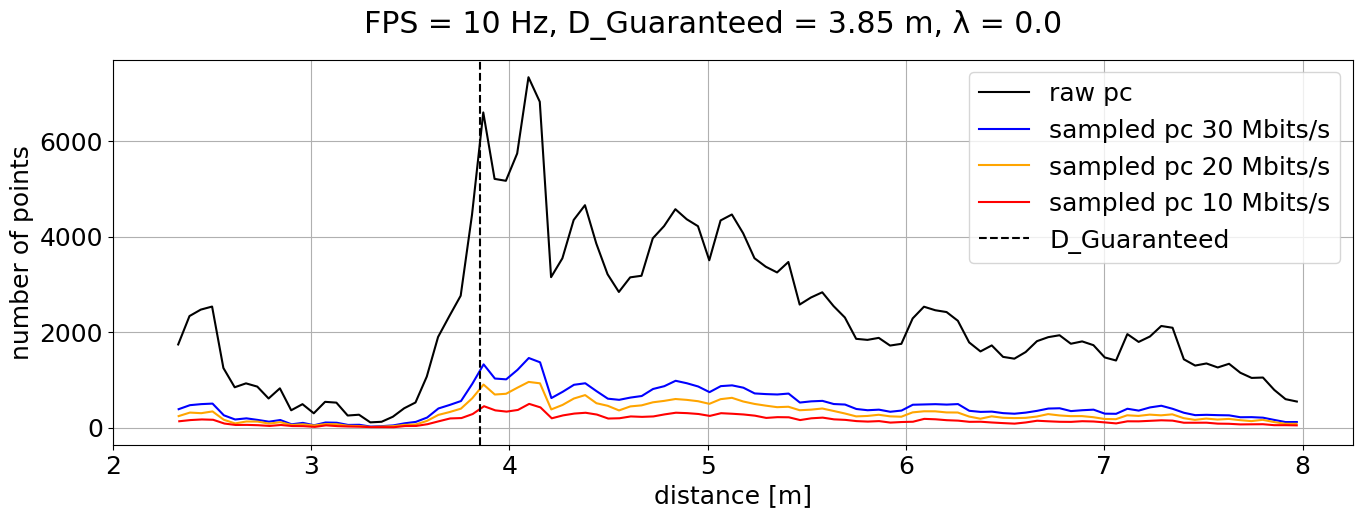

In [20]:

#print(valid_points_20)





# print cdf on z for original and sampled point cloud

# plot with size of plot 5x2
# subplots 3x1
BINS_FOR_PLOT = 100

min_z = points[:,2].min()
max_z = points[:,2].max()
print("min_z", min_z)
print("max_z", max_z)

bins = np.linspace(min_z, max_z, BINS_FOR_PLOT)




def plot_hist_line(data, bins, label, color):
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.plot(bin_centers, counts, label=label, color=color)


# Plot the histograms with lines
plt.figure(figsize=(16,5))
plt.suptitle("FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed)+" m, λ = "+str(9))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
#plot_hist_line(valid_points_40_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 40 Mbits/s', 'red')
plot_hist_line(valid_points_30_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 30 Mbits/s', 'blue')
plot_hist_line(valid_points_20_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 20 Mbits/s', 'orange')
#plot_hist_line(valid_points_15_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 15 Mbits/s', 'orange')
plot_hist_line(valid_points_10_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 10 Mbits/s', 'red')
#plot_hist_line(valid_points_5_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 5 Mbits/s', 'blue')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()

plt.figure(figsize=(16,5))
plt.suptitle("FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed)+" m, λ = "+str(7))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
#plot_hist_line(valid_points_40_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 40 Mbits/s', 'red')
plot_hist_line(valid_points_30_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 30 Mbits/s', 'blue')
plot_hist_line(valid_points_20_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 20 Mbits/s', 'orange')
#plot_hist_line(valid_points_15_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 15 Mbits/s', 'orange')
plot_hist_line(valid_points_10_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 10 Mbits/s', 'red')
#plot_hist_line(valid_points_5_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 5 Mbits/s', 'blue')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()

plt.figure(figsize=(16,5))
plt.suptitle("FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed)+" m, λ = "+str(3.0))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
#plot_hist_line(valid_points_40_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 40 Mbits/s', 'red')
plot_hist_line(valid_points_30_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 30 Mbits/s', 'blue')
plot_hist_line(valid_points_20_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 20 Mbits/s', 'orange')
#plot_hist_line(valid_points_15_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 15 Mbits/s', 'orange')
plot_hist_line(valid_points_10_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 10 Mbits/s', 'red')
#plot_hist_line(valid_points_5_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 5 Mbits/s', 'blue')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()

plt.figure(figsize=(16,5))
plt.suptitle("FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed)+" m, λ = "+str(1.0))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
#plot_hist_line(valid_points_40_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 40 Mbits/s', 'red')
plot_hist_line(valid_points_30_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 30 Mbits/s', 'blue')
plot_hist_line(valid_points_20_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 20 Mbits/s', 'orange')
#plot_hist_line(valid_points_15_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 15 Mbits/s', 'orange')
plot_hist_line(valid_points_10_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 10 Mbits/s', 'red')
#plot_hist_line(valid_points_5_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 5 Mbits/s', 'blue')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))

# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(figsize=(16,5))
plt.suptitle("FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed)+" m, λ = "+str(0.0))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
#plot_hist_line(valid_points_40_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 40 Mbits/s', 'red')
plot_hist_line(valid_points_30_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 30 Mbits/s', 'blue')
plot_hist_line(valid_points_20_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 20 Mbits/s', 'orange')
#plot_hist_line(valid_points_15_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 15 Mbits/s', 'orange')
plot_hist_line(valid_points_10_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 10 Mbits/s', 'red')
#plot_hist_line(valid_points_5_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc 5 Mbits/s', 'blue')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()
plt.show()




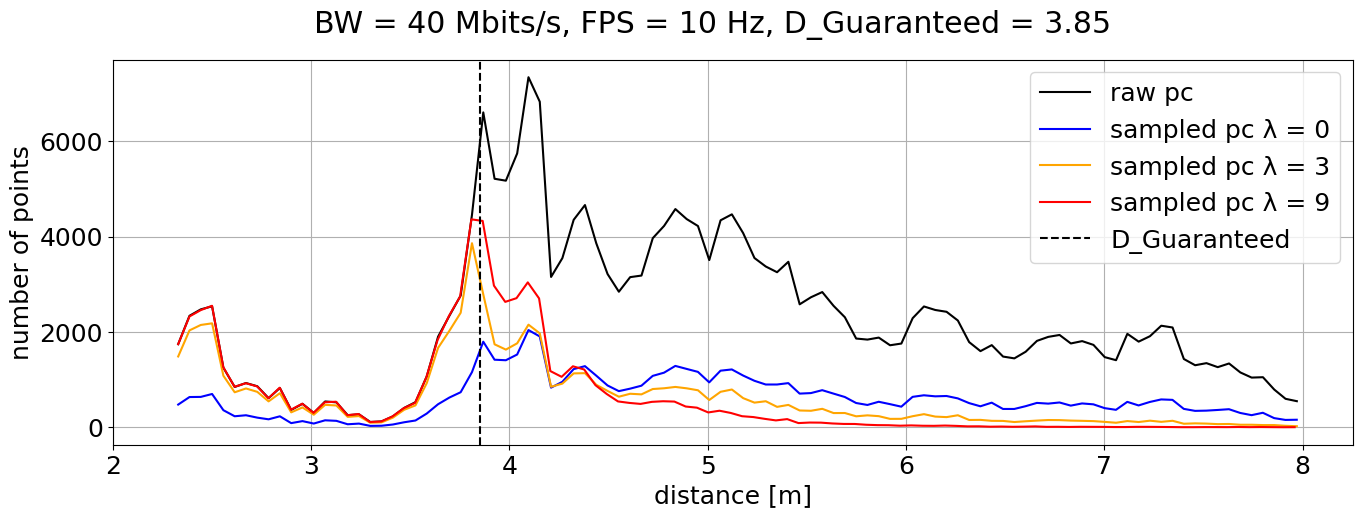

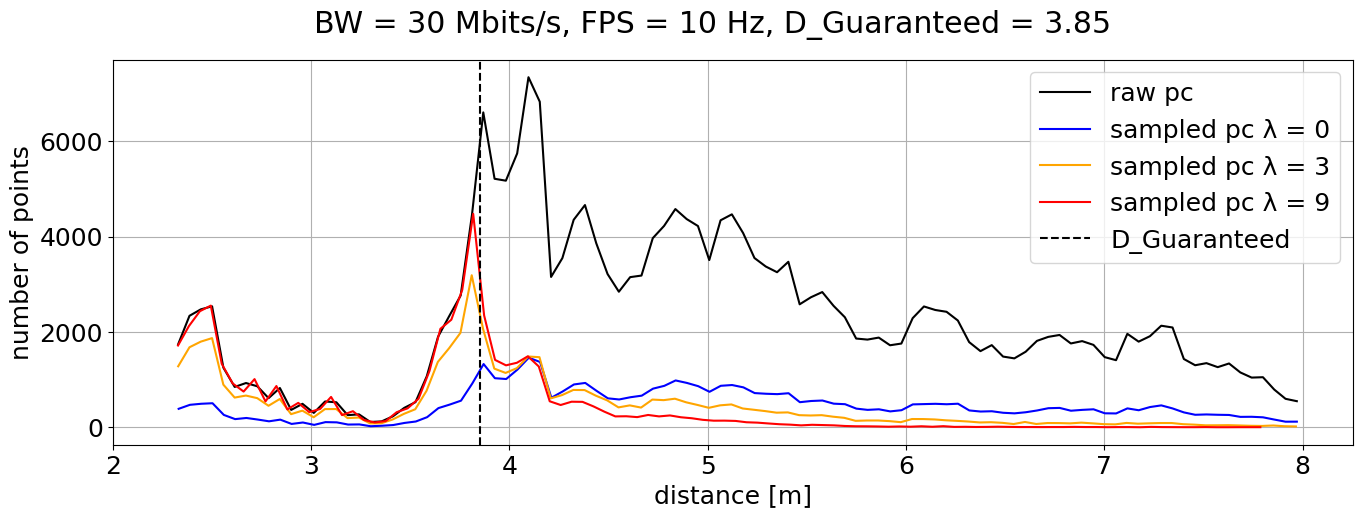

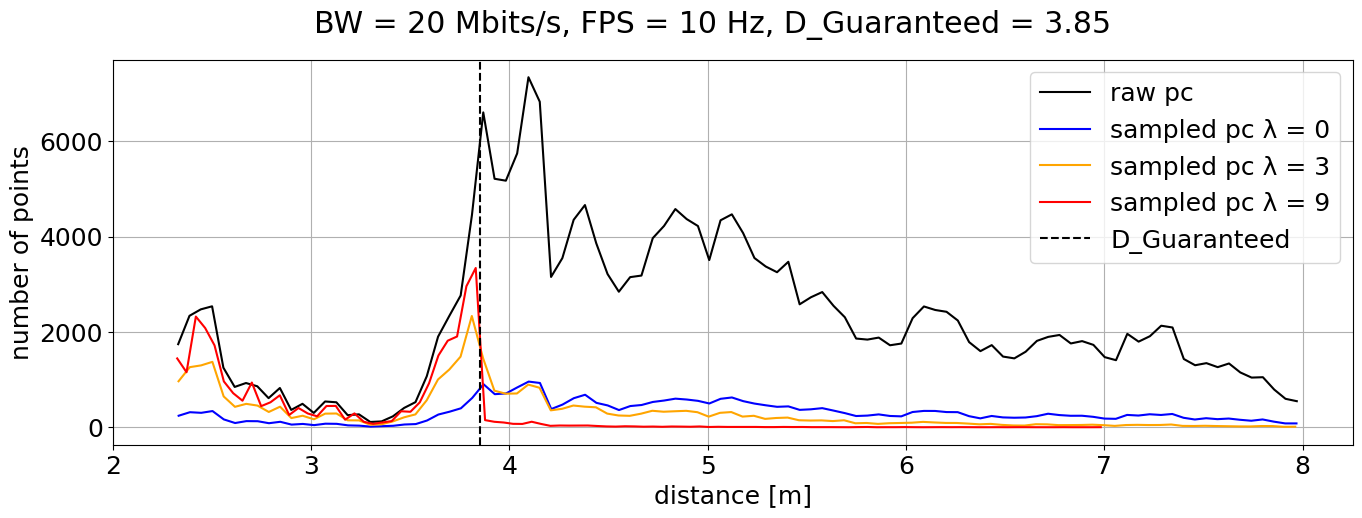

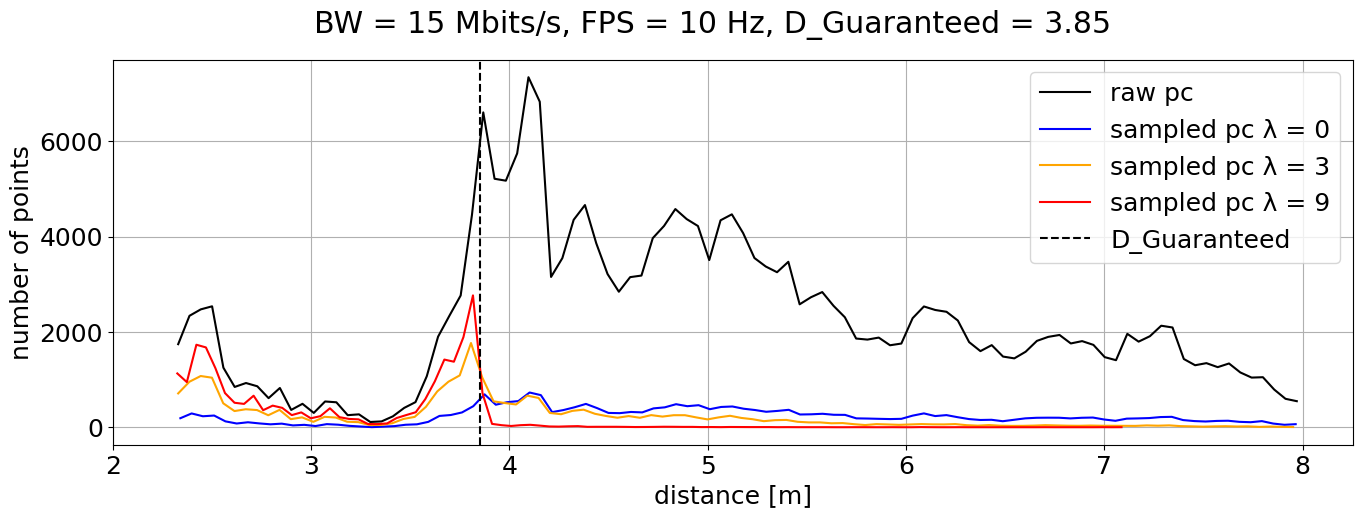

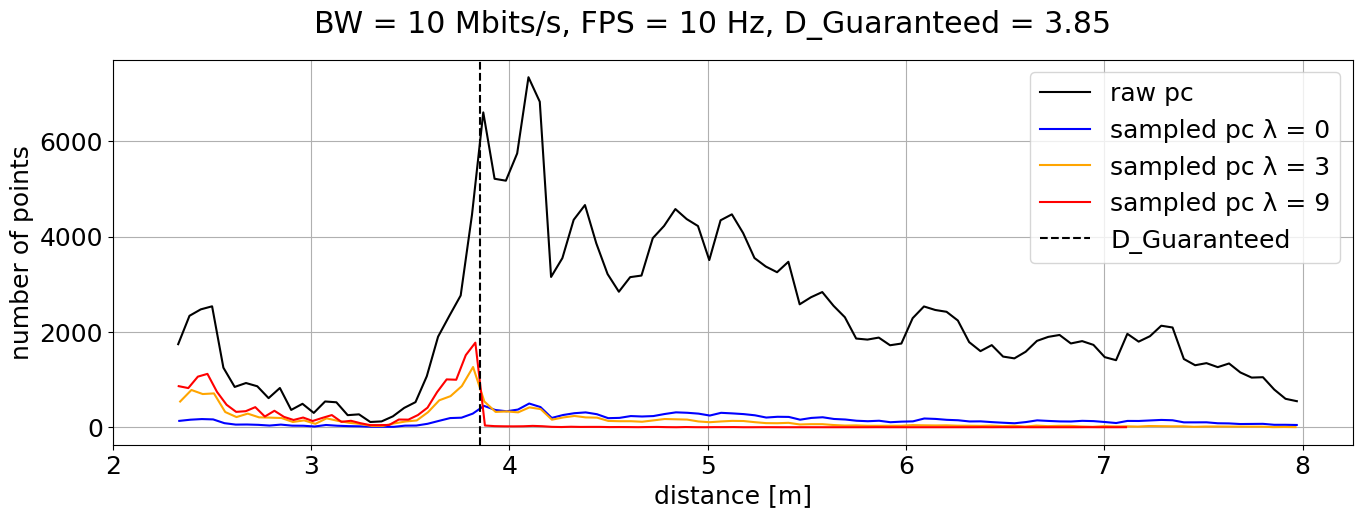

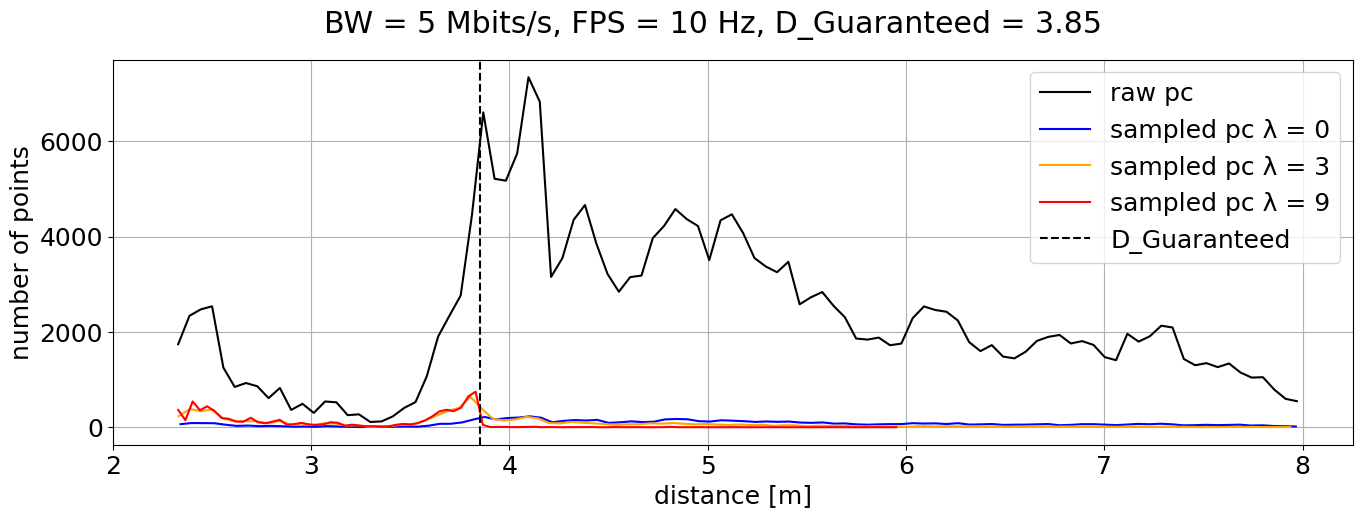

In [21]:
# plot with 40 mbits comparing different λ with lines

plt.figure(figsize=(16, 5))
plt.suptitle("BW = "+str(40)+" Mbits/s, FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
plot_hist_line(valid_points_40_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 0', 'blue')
#plot_hist_line(valid_points_40_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 1', 'orange')
plot_hist_line(valid_points_40_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 3', 'orange')
#plot_hist_line(valid_points_40_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 7', 'blue')
plot_hist_line(valid_points_40_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 9', 'red')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()


# plot with 30 mbits comparing different λ with lines

plt.figure(figsize=(16, 5))
plt.suptitle("BW = "+str(30)+" Mbits/s, FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
plot_hist_line(valid_points_30_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 0', 'blue')
#plot_hist_line(valid_points_30_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 1', 'orange')
plot_hist_line(valid_points_30_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 3', 'orange')
#plot_hist_line(valid_points_30_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 7', 'blue')
plot_hist_line(valid_points_30_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 9', 'red')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()

# plot with 20 mbits comparing different λ with lines

plt.figure(figsize=(16, 5))
plt.suptitle("BW = "+str(20)+" Mbits/s, FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
plot_hist_line(valid_points_20_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 0', 'blue')
#plot_hist_line(valid_points_20_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 1', 'orange')
plot_hist_line(valid_points_20_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 3', 'orange')
#plot_hist_line(valid_points_20_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 7', 'blue')
plot_hist_line(valid_points_20_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 9', 'red')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# plot with 15 mbits comparing different λ with lines

plt.figure(figsize=(16, 5))
plt.suptitle("BW = "+str(15)+" Mbits/s, FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
plot_hist_line(valid_points_15_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 0', 'blue')
#plot_hist_line(valid_points_15_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 1', 'orange')
plot_hist_line(valid_points_15_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 3', 'orange')
#plot_hist_line(valid_points_15_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 7', 'blue')
plot_hist_line(valid_points_15_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 9', 'red')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# plot with 10 mbits comparing different λ with lines
plt.figure(figsize=(16, 5))
plt.suptitle("BW = "+str(10)+" Mbits/s, FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
plot_hist_line(valid_points_10_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 0', 'blue')
#plot_hist_line(valid_points_10_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 1', 'orange')
plot_hist_line(valid_points_10_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 3', 'orange')
#plot_hist_line(valid_points_10_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 7', 'blue')
plot_hist_line(valid_points_10_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 9', 'red')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# plot with 5 mbits comparing different λ with lines
plt.figure(figsize=(16, 5))
plt.suptitle("BW = "+str(5)+" Mbits/s, FPS = "+str(FPS)+" Hz, D_Guaranteed = "+str(D_Guaranteed))
plot_hist_line(points[:,2].numpy(), BINS_FOR_PLOT, 'raw pc', 'black')
plot_hist_line(valid_points_5_0[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 0', 'blue')
#plot_hist_line(valid_points_5_1[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 1', 'orange')
plot_hist_line(valid_points_5_3[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 3', 'orange')
#plot_hist_line(valid_points_5_7[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 7', 'blue')
plot_hist_line(valid_points_5_9[:,2].numpy(), BINS_FOR_PLOT, 'sampled pc λ = 9', 'red')
plt.xlabel("distance [m]")
plt.ylabel("number of points")
plt.xticks(np.arange(int(min_z-0.2), max_z+1, 1))
# vertical line at D_Guaranteed
plt.axvline(x=D_Guaranteed, color='black', linestyle='--', label='D_Guaranteed')
plt.legend(loc='upper right')
plt.grid()
plt.show()







